### Imports

If working in a [suite2p](https://github.com/MouseLand/suite2p) conda environment initialized according to the guide [here](https://github.com/MouseLand/suite2p#installation), using the provided [environment.yml](https://github.com/MouseLand/suite2p/blob/main/environment.yml), all of these dependencies should all be present, with the exception of `skimage`. To obtain it, execute `conda install scikit-image` in your terminal while your **suite2p** conda environment is active. 

Pytorch, and another repository of mine are now also dependencies, but they are only used toward the end after the PCA section in some experimental clustering attempts. These cells can be commented out (along with the dependencies if you want to use this notebook and not set those up).

In [1]:
import os
import re
import shutil
import sys
from datetime import date

import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.patches import Rectangle

from skimage import io
from skimage import measure
from tifffile import imsave

from scipy import signal
from scipy.interpolate import interp2d
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import cluster

# local imports
from image_arrays import *
from s2p_packer import unpack_hdf

sys.path.append('../python-analysis')
import torch_clustering as clorch
import cluster_ae_builds as builds
from conv1d_deep_cluster import Conv1dDeepClusterer

### Activate interactive plotting
By default, inline plots are static. Here we specify one of two options (comment out the undesired command) that will open plots with GUI controls for us.
- **qt ->** figures opened in windows outside the notebook
- **notebook ->** figures within notebook underneath generating cell.

In [2]:
# %matplotlib qt 
%matplotlib notebook

### Paths describing folder structure used for loading in videos and data archives
These, along with naming of the files when they come up, should be altered to align with your setup.

In [3]:
base_path = "/mnt/Data/prerna_noise/spontaneous/"
tiff_path = os.path.join(base_path, "")

In [4]:
stacks = np.stack(
    [
        io.imread(os.path.join(tiff_path, f))
        for f in os.listdir(tiff_path) 
        if (f.endswith(".tiff") or f.endswith(".tif"))
    ],
    axis=0
)
mean_stack_proj = np.mean(stacks, axis=(0, 1))
n_trials, n_frames, n_rows, n_cols = stacks.shape 

hz = 58.2487
recs_xaxis = np.arange(n_frames) * (1 / hz)

# physical dimensions (in microns)
rec_width = 71.7
rec_height = 28.94
pix_w = rec_width / n_cols
pix_h = rec_height / n_rows

print("stacks shape:", stacks.shape)

stacks shape: (1, 8000, 60, 256)


### Dynamic ROI plot of recordings
Trial to display in the stack axis can be selected with the slider, with the last position being the average. Use mouse scroll to cycle through frames of the movies. Beams of the outlined ROI are displayed below with the current trial highlighted in red. The average beam is displayed with a thicker linewidth and greater opacity.

**NOTE:** If the recordings are large, this will use up a lot of RAM.

<IPython.core.display.Javascript object>


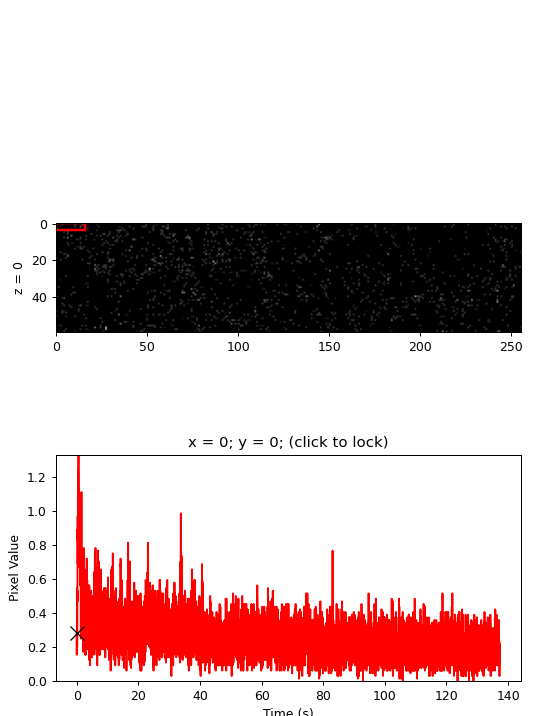

Recording shape: (8000, 60, 256)


In [5]:
stacks_plot = StackExplorer(
    stacks,
    zaxis=recs_xaxis,
    delta=5,
    roi_sz=(16, 4),
#     vmin=0,
    auto_roi_scale=True,
    figsize=(6, 8)
)
stacks_plot.ax[1].set_xlabel("Time (s)")
stacks_plot.ax[1].set_ylabel("Pixel Value")

print("Recording shape:", stacks[0].shape)
stacks_plot.fig.show()

### Grid ROI placement using Quality Index acceptance threshold
Take `grid_w` by `grid_h` beams from the scan field and discard those that do not meet the `min_qi` threshold.

In [6]:
grid_w = 8
grid_h = 6
grid_cols = n_cols // grid_w
grid_rows = n_rows // grid_h

grid_recs, grid_idxs, all_qis, accepted_qis = [[] for _ in range(4)]
for x0 in range(0, n_cols, grid_w):
    for y0 in range(0, n_rows, grid_h):
        beams = np.mean(stacks[:, :, y0:y0 + grid_h, x0:x0 + grid_w], axis=(2, 3))
        grid_recs.append(beams)
        grid_idxs.append([x0, y0])

grid_recs = np.stack(grid_recs, axis=1)
avg_grid_recs = np.mean(grid_recs, axis=0)
grid_idxs = np.stack(grid_idxs, axis=0)
grid_locs = grid_idxs * np.array([pix_w, pix_h])
print("number of grid ROIs accepted:", grid_recs.shape[1])
print("grid_cols = %i, grid_rows = %i" % (grid_cols, grid_rows))

number of grid ROIs accepted: 320
grid_cols = 32, grid_rows = 10


### Quality Index distribution and accepted ROI map
Histogram includes the entire distribution of QIs, while the plot below highlights the locations of the passable QI ROIs in space. Red squares with red QI indicate ROIs that have been accepted, white values correspond to ROIs that did not reach the quality index threshold `min_qi`.

<IPython.core.display.Javascript object>


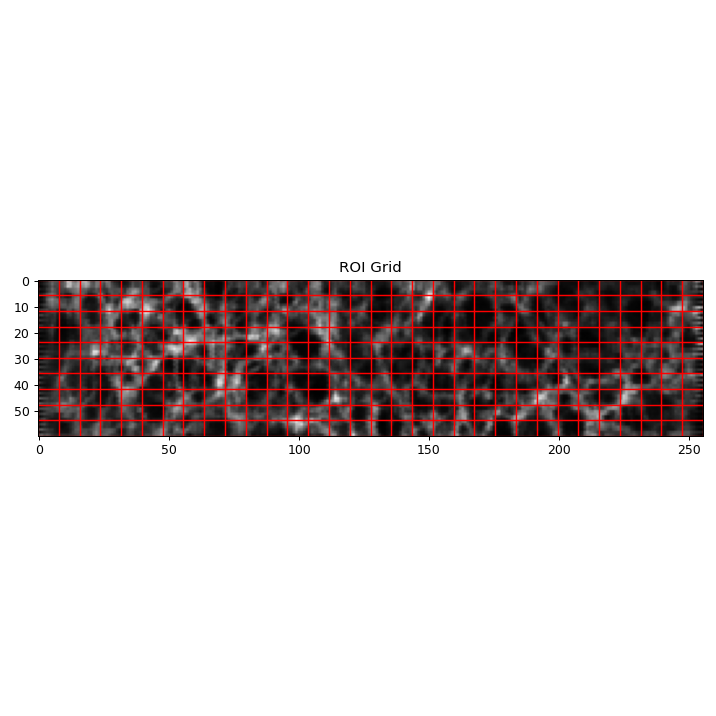

In [7]:
half_w = grid_w / 2
half_h = grid_h / 2
grid_fig, grid_ax = plt.subplots(1, figsize=(8, 8))

grid_ax.imshow(mean_stack_proj, cmap="gray")
grid_ax.set_title("ROI Grid")

for (x, y) in grid_idxs:
    grid_ax.add_patch(
        Rectangle(
            (x - .5, y - .5),  # grid offset
            grid_w, 
            grid_h, 
            fill=False,
            color="red",
            linewidth=1,
            linestyle="-"
        )
    )

grid_fig.tight_layout()

### Signal-noise normalize ROI responses

In [8]:
# normalize to noise and remove offset
grid_recs /= np.var(grid_recs[:, :, -150:], axis=2).reshape(*grid_recs.shape[:2], 1)
grid_recs -= np.mean(grid_recs[:, :, -150:], axis=2).reshape(*grid_recs.shape[:2], 1)
avg_grid_recs /= np.var(avg_grid_recs[:, -150:], axis=1).reshape(avg_grid_recs.shape[0], 1)
avg_grid_recs -= np.mean(avg_grid_recs[:, -150:], axis=1).reshape(avg_grid_recs.shape[0], 1)

grid_butt = butter_lowpass_filter(grid_recs, 10, hz)
grid_svgl = signal.savgol_filter(grid_recs, 31, polyorder=3, axis=-1)
grid_butt_svgl = signal.savgol_filter(grid_butt, 15, polyorder=3, axis=-1)
grid_roll = rolling_average(grid_recs, n=31)

### Explore signals from ROIs, and peak finding parameters
Use scroll wheel to cycle between ROIs, and the input boxes below to
adjust parameters for the peak finding algorithm (see `scipy.signal.find_peaks` for more documentation).

- **prominence:** target difference between a peak and its surrounding mean
- **width:** number of points the value must remain within the fractional **tolerance** range of the peak in order to be considered
- **distance:** minimum allowable interval between peak candidates

<IPython.core.display.Javascript object>


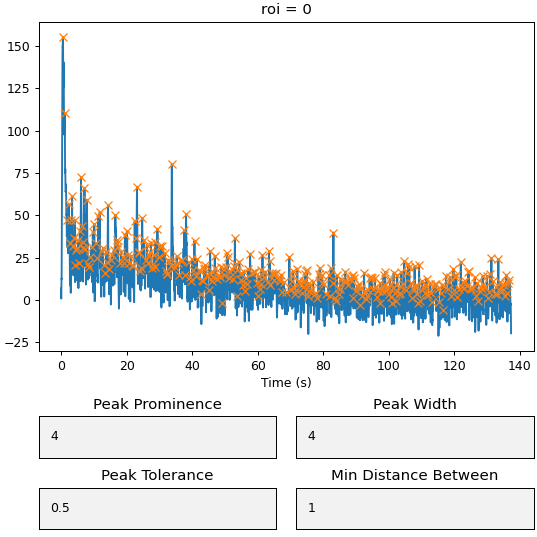

In [9]:
peak_explorer = PeakExplorer(
    recs_xaxis, 
#     recs_xaxis[2500:], 
#     grid_recs[0],
#     grid_svgl[0],
#     grid_roll[0],
#     grid_butt[0],
    grid_butt_svgl[0],
#     grid_butt_svgl[0][:, 2500:],
#     signal.detrend(grid_butt_svgl[0][:, 2500:]),
    prominence=4,
    width=4,
    tolerance=.5,
    distance=1
)

### MSE and cross-correlation between all ROIs

For each ROI calculate the MSE/cross-correlation with each other ROI (for a section of the recording, e.g. skipping the laser response). Scalar correlation metrics will be plotted aginst distance, and cross-correlations will be explored interactively. Hopefully this will give a sense of how quickly similarity of spontaneous responses fall off over space.

In [10]:
# recs = grid_recs[0][:, 2500:]
# recs = signal.detrend(grid_recs[0][:, 2500:])
recs = signal.detrend(grid_recs[0][:, 5000:])
# recs = grid_butt[0][:, 2500:]
recs = np.stack([r - r.mean() for r in recs], axis=0)
# self_full_corr = np.ones((recs.shape[1] * 2 - 1))
mid_idx = recs.shape[-1] // 2
win_dur = 0.1
win_pts = int(win_dur * hz)
self_same_corr = np.ones((recs.shape[1]))

dists = []
mses = []
peak_corrs = []
win_corrs = []
mse_dict = {i: {i: 0.} for i in range(recs.shape[0])}
corr_dict = {i: {i: self_same_corr} for i in range(recs.shape[0])}
peak_corr_dict = {i: {i: 1.} for i in range(recs.shape[0])}
win_corr_dict ={i: {i: 1.} for i in range(recs.shape[0])}

for i in range(recs.shape[0] - 1):
    for j in range(i + 1, recs.shape[0]):
        dist = np.sqrt(np.sum((grid_locs[i] - grid_locs[j]) ** 2))
        mse = np.sum((recs[i] - recs[j]) ** 2)
        corr = signal.correlate(recs[i], recs[j], mode="same")
        peak_corr = np.max(corr)
        win_corr = np.sum(corr[mid_idx - win_pts:mid_idx + win_pts])
        dists.append(dist)
        mses.append(mse)
        peak_corrs.append(peak_corr)
        win_corrs.append(win_corr)
        mse_dict[i][j] = mse
        mse_dict[j][i] = mse
        corr_dict[i][j] = corr
        corr_dict[j][i] = corr
        peak_corr_dict[i][j] = peak_corr
        peak_corr_dict[j][i] = peak_corr
        win_corr_dict[i][j] = win_corr
        win_corr_dict[j][i] = win_corr

dists = np.array(dists)
mses = np.array(mses)
peak_corrs = np.array(peak_corrs)
win_corrs = np.array(win_corrs)

<IPython.core.display.Javascript object>


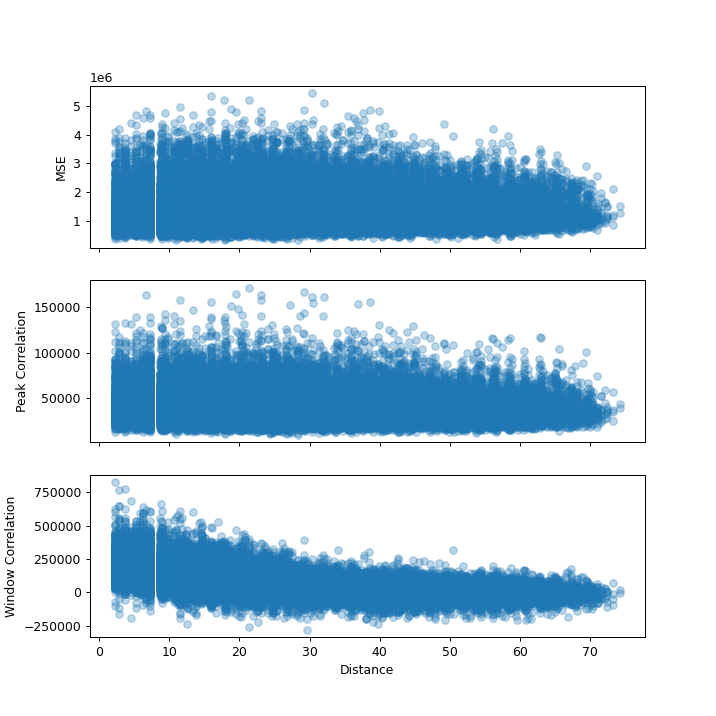

In [23]:
dists_fig, dists_ax = plt.subplots(3, sharex=True, figsize=(8, 8))

dists_ax[0].scatter(dists, mses, alpha=0.3)
dists_ax[0].set_ylabel("MSE")

dists_ax[1].scatter(dists, peak_corrs, alpha=0.3)
dists_ax[1].set_ylabel("Peak Correlation")

dists_ax[2].scatter(dists, win_corrs, alpha=0.3)
dists_ax[2].set_ylabel("Window Correlation")

dists_ax[-1].set_xlabel("Distance")
dists_fig.show()

<IPython.core.display.Javascript object>


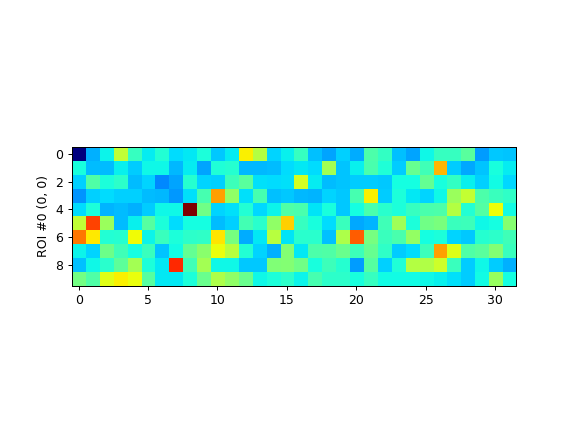

In [14]:
mse_grid_stack = np.stack(
    [
        np.array([m for _, m in sorted(ms.items())]).reshape(grid_rows, grid_cols)
        for i, ms in mse_dict.items()
    ],
    axis=0,
)

mse_grid_fig, mse_grid_ax = plt.subplots(1)
mse_grid_plot = StackPlotter(
    mse_grid_fig,
    mse_grid_ax,
    mse_grid_stack,
    delta=1,
    cmap="jet",
    z_fmt_fun=lambda i: "ROI #%i (%i, %i)" % (i, i % grid_cols, i // grid_cols),
)
mse_grid_fig.show()

In [15]:
corr_grid_stack = np.stack(
    [
        np.stack(
            [c for _, c in sorted(cs.items())], axis=0
        ).reshape(1, grid_rows, grid_cols, -1).transpose(0, 3, 1, 2)
        for i, cs in corr_dict.items()
    ],
    axis=0,
)

<IPython.core.display.Javascript object>


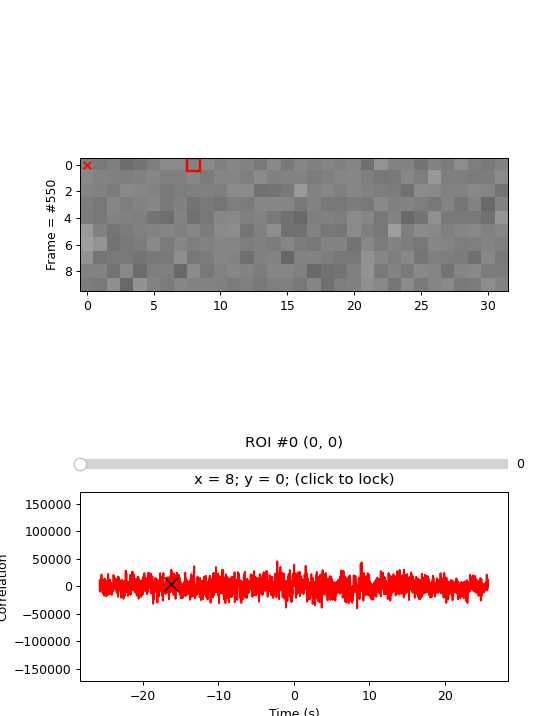

In [16]:
xaxis = np.arange(recs.shape[1]) * (1 / hz)
corr_plot = StackExplorer(
    corr_grid_stack,
#     zaxis=(recs_xaxis - (recs_xaxis.max() / 2)),
    zaxis=(xaxis - (xaxis.max() / 2)),
    delta=10,
    roi_sz=1,
#     vmin=0,
#     auto_roi_scale=True,
    auto_roi_scale=False,
    z_fmt_fun=(lambda i: "Frame #%i" % i),
    n_fmt_fun=lambda i: "ROI #%i (%i, %i)" % (i, i % grid_cols, i // grid_cols),
    figsize=(6, 8)
)
corr_plot.ax[2].set_xlabel("Time (s)")
corr_plot.ax[2].set_ylabel("Correlation")

corr_mark = corr_plot.ax[0].scatter([0], [0], marker="x", c="red")
corr_plot.n_slider.on_changed(
    lambda v: corr_mark.set_offsets([[v % grid_cols, v // grid_cols]]))

corr_plot.fig.show()

<IPython.core.display.Javascript object>


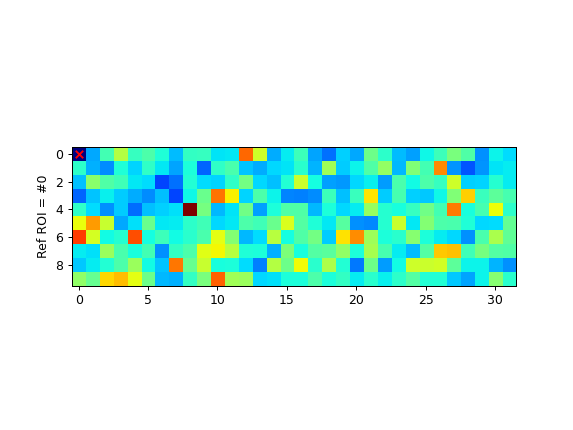

In [17]:
peak_corr_grid_stack = np.stack(
    [
        np.array([p for _, p in sorted(ps.items())]).reshape(grid_rows, grid_cols)
        for i, ps in peak_corr_dict.items()
    ],
    axis=0,
)

peak_corr_grid_fig, peak_corr_grid_ax = plt.subplots(1)
peak_corr_grid_plot = StackPlotter(
    peak_corr_grid_fig,
    peak_corr_grid_ax,
    peak_corr_grid_stack,
    delta=1,
    z_fmt_fun=(lambda i: "Ref ROI = #%i" % i),
    cmap="jet"
)

peak_corr_mark = peak_corr_grid_plot.ax.scatter([0], [0], marker="x", c="red")
peak_corr_grid_plot.fig.canvas.mpl_connect(
    "scroll_event",
    lambda e: peak_corr_mark.set_offsets(
        [[peak_corr_grid_plot.idx % grid_cols, peak_corr_grid_plot.idx // grid_cols]]
    )
)

peak_corr_grid_fig.show()

<IPython.core.display.Javascript object>


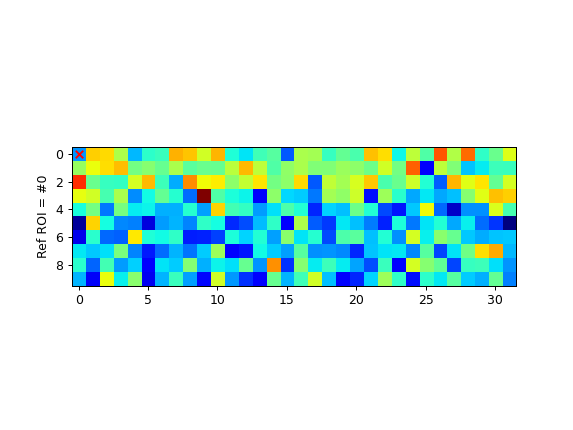

In [18]:
win_corr_grid_stack = np.stack(
    [
        np.array([p for _, p in sorted(ps.items())]).reshape(grid_rows, grid_cols)
        for i, ps in win_corr_dict.items()
    ],
    axis=0,
)

win_corr_grid_fig, win_corr_grid_ax = plt.subplots(1)
win_corr_grid_plot = StackPlotter(
    win_corr_grid_fig,
    win_corr_grid_ax,
    win_corr_grid_stack,
    delta=1,
    z_fmt_fun=(lambda i: "Ref ROI = #%i" % i),
    cmap="jet"
)


win_corr_mark = win_corr_grid_plot.ax.scatter([0], [0], marker="x", c="red")
win_corr_grid_plot.fig.canvas.mpl_connect(
    "scroll_event",
    lambda e: win_corr_mark.set_offsets(
        [[win_corr_grid_plot.idx % grid_cols, win_corr_grid_plot.idx // grid_cols]]
    )
)

win_corr_grid_fig.show()